In [9]:
# Settings for autoreloading.

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import wandb
wandb.login(key='d3d31786e16c5dffe9ee01690d0bb069cac55e84', relogin=True, force=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\riccardo/.netrc


True

In [11]:
import random
from pathlib import Path
from typing import Dict, Any

import torch
import wandb


def get_model_dictionary(artifact_name: str, project_name: str) -> Dict[str, Any]:
    """Download a model from wandb and get its values.

    Parameters
    ----------
    at_name : str
        The name of the artifact to download.
    project_name : str
        The name of the project to download the artifact from.
    
    Returns
    -------
    list of str
        The list of files in the downloaded dataset.
    """
    def _get_model(run: Any):
        artifact_path = f'ai-industry/{project_name}/{artifact_name}'
        artifact = run.use_artifact(artifact_path, type='model')
        return artifact.download()

    if wandb.run is not None:
        run = wandb.run
        artifact_dir = _get_model(run)
    else:
        run = wandb.init(project=project_name, job_type='download_model')
        artifact_dir = _get_model(run)
        run.finish()
    # Get the file name
    [file_name] = sorted(list(Path(artifact_dir).iterdir()))
    model_dictionary = torch.load(file_name)
    if 'model_parameters' not in model_dictionary:
        # TODO: remove: Set random number of model parameters
        model_dictionary['model_parameters'] = random.randint(100, 1000)
    return model_dictionary

In [12]:
models = [
    'cloud-diffuser-baseline',
    'cloud-diffuser-baseline-no-autoregression',
    'cloud-diffuser-baseline-autoregression'
]
models_artifacts = { m: 'unet_small:latest' for m in models }
models_dictionaries = { m: get_model_dictionary(v, m) for m, v in models_artifacts.items() }

In [13]:
import matplotlib.pyplot as plt

def plot_metric(metric: str, metric_label: str, models_dictionaries: Dict[str, Any]):
    plt.figure(figsize=(8, 5))
    labels = []
    for i, (model, d) in enumerate(models_dictionaries.items()):
        label = model.removeprefix('cloud-diffuser-')
        label = ' '.join([w.capitalize() for w in label.split('-')])
        labels.append(label)
        plt.bar(
            i,
            height=d[metric],
            width=.3,
            edgecolor='black',
            )
    plt.title('Validation mCSI comparison for the Different Models')
    plt.ylabel(f'Valdidation {metric_label}')
    plt.tight_layout()
    plt.xlabel('Model Name')
    plt.margins(.3, .5)
    plt.xticks(range(len(models_dictionaries)), labels, rotation=45, ha='right')
    plt.show()

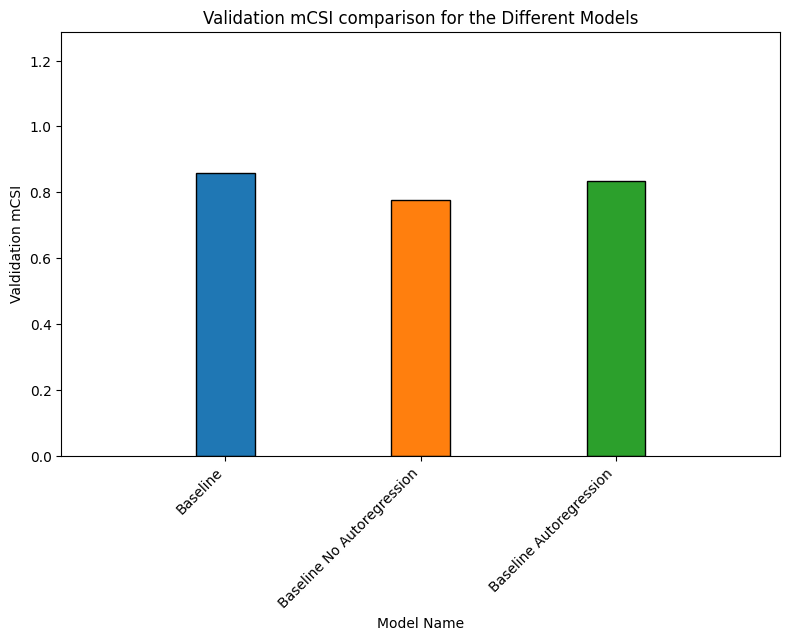

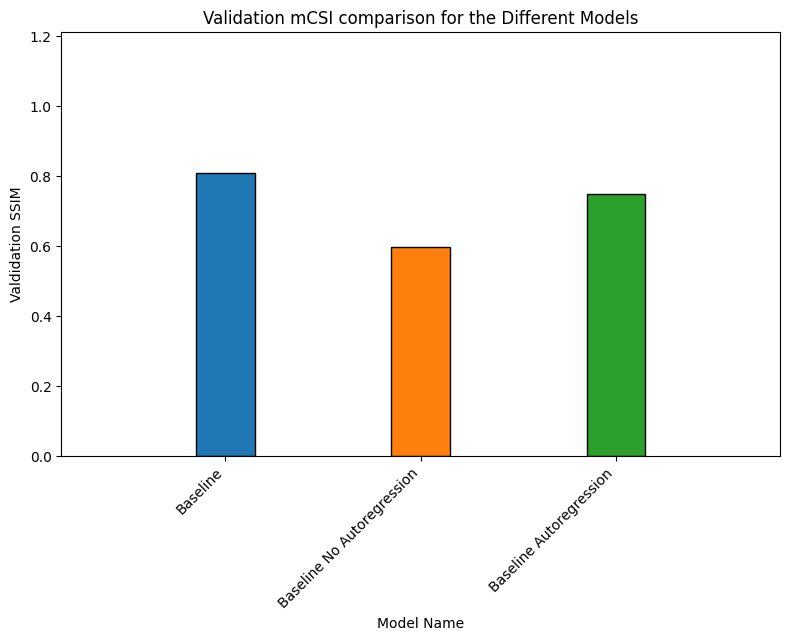

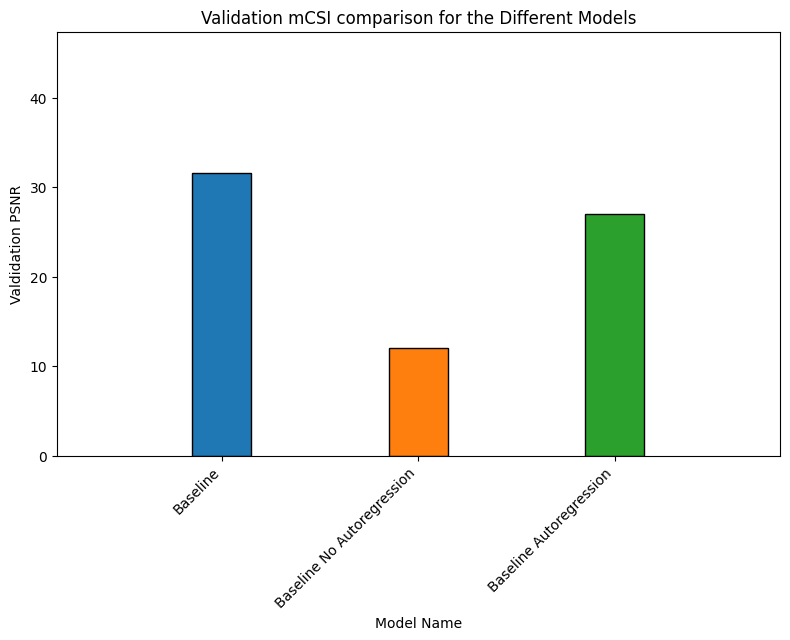

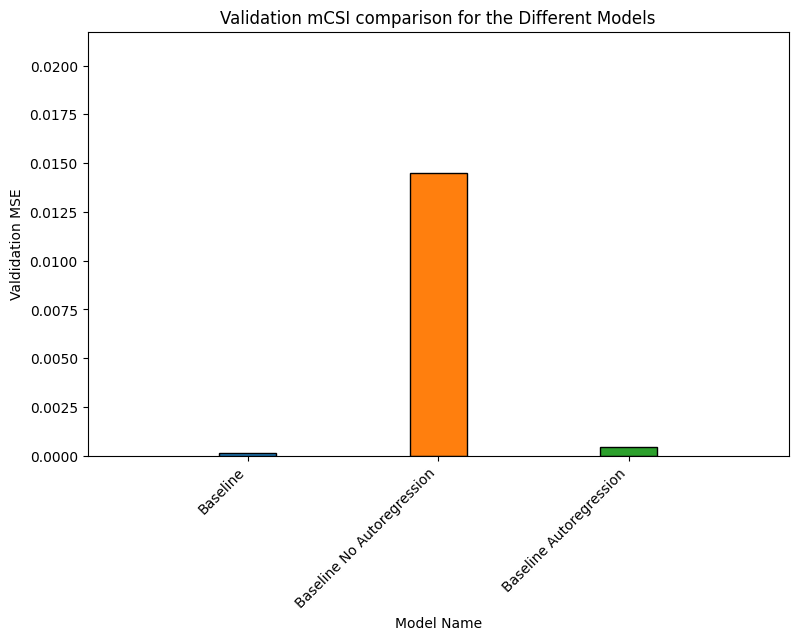

In [14]:
plot_metric('val_m_csi', 'mCSI', models_dictionaries)
plot_metric('val_ssim', 'SSIM', models_dictionaries)
plot_metric('val_psnr', 'PSNR', models_dictionaries)
plot_metric('val_mse', 'MSE', models_dictionaries)

In [15]:
import matplotlib.pyplot as plt

def plot_model_parameters(models_dictionaries: Dict[str, Any]):
    plt.figure(figsize=(8, 5))
    for model, d in models_dictionaries.items():
        label = model.removeprefix('cloud-diffuser-')
        label = ' '.join([w.capitalize() for w in label.split('-')])
        plt.scatter(
            d['model_parameters'],
            d['val_m_csi'],
            s=90,
            marker='D',
            label=label,
            edgecolors='black'
            )
    plt.legend(loc='lower right')
    plt.title('Validation mCSI with respect to Model Parameters Number')
    plt.ylabel('Valdidation mCSI')
    plt.tight_layout()
    plt.xlabel('Model Parameters Number')
    plt.margins(.2, .2)
    plt.xscale('log')
    plt.show()

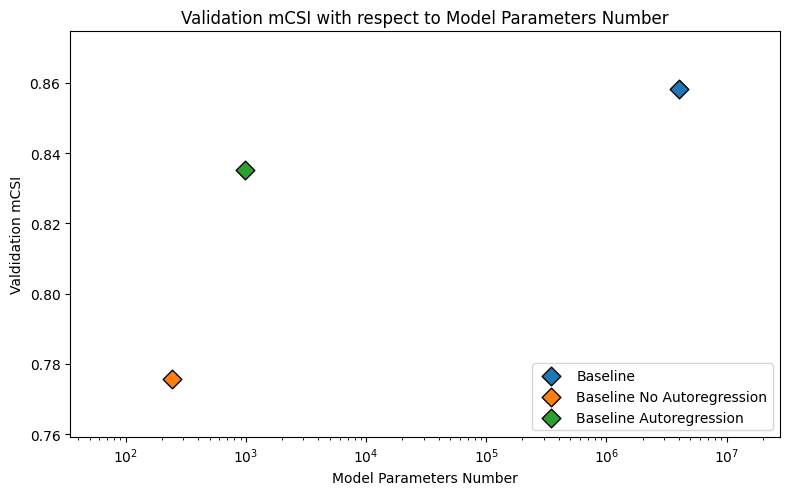

In [16]:
plot_model_parameters(models_dictionaries)